In [1]:
import tensorflow as tf
import modules.layers as tf_util
import modules.utility as util
import numpy as np
import tables
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from IPython.display import display, Javascript

disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""

def disable_scroll():
    display(Javascript(disable_js))
    print ("autoscrolling long output is disabled")
    
disable_scroll()

#######################################################
# Get data
#############
#CT Dataset
data_path = '/media/marsdenlab/Data2/datasets/DeepLofting/'
train = data_path+'train_192_ct.hdf5'
val = data_path+'val_192_ct.hdf5'
test = data_path+'test_192_ct.hdf5'
MODEL_CODE = 'CT'

#MR Dataset
# train = data_path+'train_192_mr.hdf5'
# val = data_path+'val_192_mr.hdf5'
# test = data_path+'test_192_mr.hdf5'
# MODEL_CODE = 'MR'

f_train = tables.open_file(train)
f_val = tables.open_file(val)

input_shape = f_train.root.X.shape
output_shape = f_train.root.Y.shape
print input_shape, output_shape

print 'data shapes, train={},{}'.format(input_shape,output_shape)
print f_val.root.X.shape

##########################################



Using TensorFlow backend.


<IPython.core.display.Javascript object>

autoscrolling long output is disabled
(108253, 192, 192, 1) (108253, 192, 192, 1)
data shapes, train=(108253, 192, 192, 1),(108253, 192, 192, 1)
(6835, 192, 192, 1)


In [2]:
######################################################
# Define variables
######################################################
N = f_train.root.X.shape[0]
Nval = f_val.root.X.shape[0]
W,H,C = f_train.root.X[0].shape
C=1
crop_dims = 128
Nbatch = 16
lr = 1e-5
Nsteps=40000
print_step=200
init = 7e-2
lam = 0.001
Nfilters = 32

EPS=1e-4
leaky_relu = tf.contrib.keras.layers.LeakyReLU(0.2)
y_index=0
alph = 0.3
beta = 0.7

In [3]:


def selu(x):
    with ops.name_scope('elu') as scope:
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
    return scale*tf.where(x>=0.0, x, alpha*tf.nn.elu(x)-alpha)
#########################################################
# Define graph
#########################################################
#lr_tf = tf.placeholder(shape=[],dtype=tf.float32,name='lr')
x = tf.placeholder(shape=[None,crop_dims,crop_dims,C],dtype=tf.float32)
y = tf.placeholder(shape=[None,crop_dims,crop_dims,C],dtype=tf.float32)

##################
# Multi resolution
##################


###############3
# Mask Layer
###############

# x_vec = tf.reshape(x, (Nbatch,crop_dims**2))

# sp = tf_util.fullyConnected(x_vec,crop_dims,leaky_relu, std='xavier', scope='sp1')
# sp = tf_util.fullyConnected(sp,crop_dims**2,leaky_relu, std='xavier', scope='sp2')
# x_vec = tf.reshape(sp, (Nbatch,crop_dims,crop_dims,1))
# x_vec_sig = tf.sigmoid(x_vec)
# masked_input = tf.multiply(x,x_vec_sig)

# loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_vec,labels=y))
# # loss = 0.0
###############
# I2I
###############

yclass,yhat,o3,o4 = tf_util.I2INet(x,nfilters=Nfilters,activation=leaky_relu,init=init)

y_vec = tf.reshape(yhat, (Nbatch,crop_dims**2))

sp = tf_util.fullyConnected(y_vec,crop_dims,leaky_relu, std='xavier', scope='sp1')
sp = tf_util.fullyConnected(y_vec,crop_dims**2,leaky_relu, std='xavier', scope='sp2')
sp = tf.reshape(sp, (Nbatch,crop_dims,crop_dims,1))

y_sp = tf_util.conv2D(sp, nfilters=Nfilters, activation=leaky_relu,init=init, scope='sp3')
y_sp_1 = tf_util.conv2D(y_sp, nfilters=Nfilters, activation=leaky_relu, init=init,scope='sp4')
y_sp_2 = tf_util.conv2D(y_sp_1, nfilters=Nfilters, activation=leaky_relu, init=init,scope='sp5')

yhat = tf_util.conv2D(y_sp_2, nfilters=1, activation=tf.identity, init=init,scope='sp6')

yclass = tf.sigmoid(yhat)

# TP = tf.reduce_sum(yclass*y)
# FP = tf.reduce_sum(yclass*(1-y))
# FN = tf.reduce_sum((1-yclass)*y)
# loss = -TP/(TP + alph*FP+beta*FN+EPS)

loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=yhat,labels=y))

loss = loss + tf_util.l2_reg(lam)

opt = tf.train.AdamOptimizer(lr)
train = opt.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

print yclass

saver = tf.train.Saver()

[16, 16384]
[16, 16384]
Tensor("Sigmoid_1:0", shape=(16, 128, 128, 1), dtype=float32)


(192, 192, 1) (192, 192)


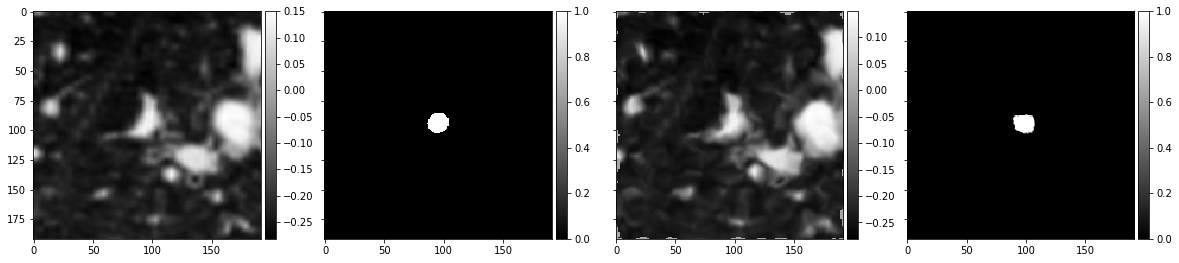

(192, 192, 1) (192, 192)


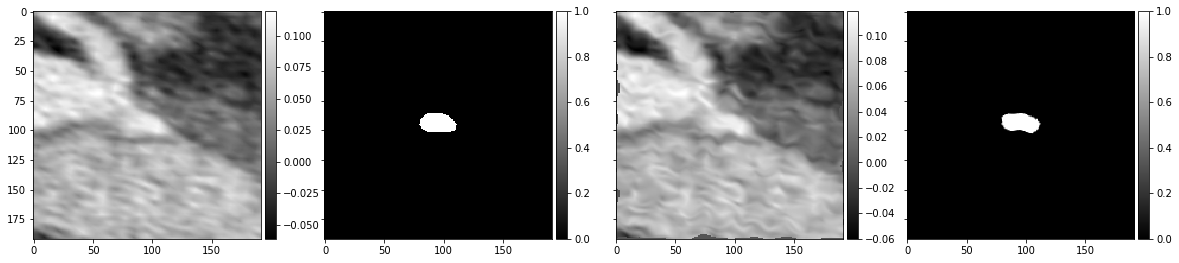

(192, 192, 1) (192, 192)


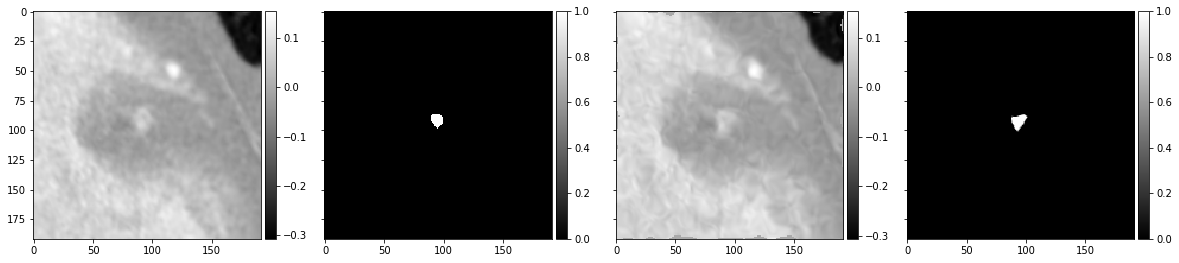

(192, 192, 1) (192, 192)


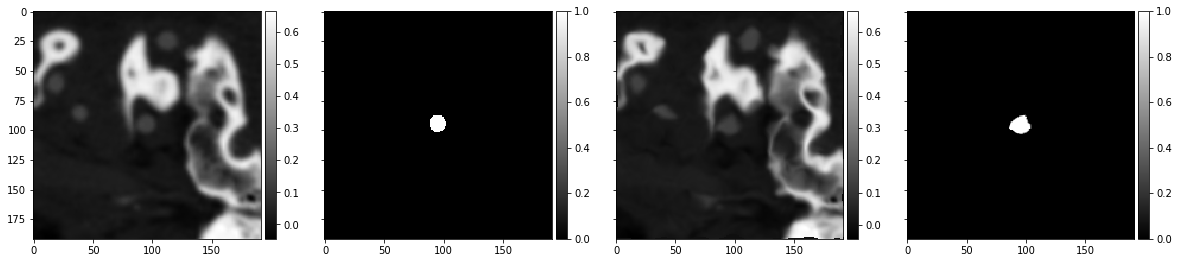

(192, 192, 1) (192, 192)


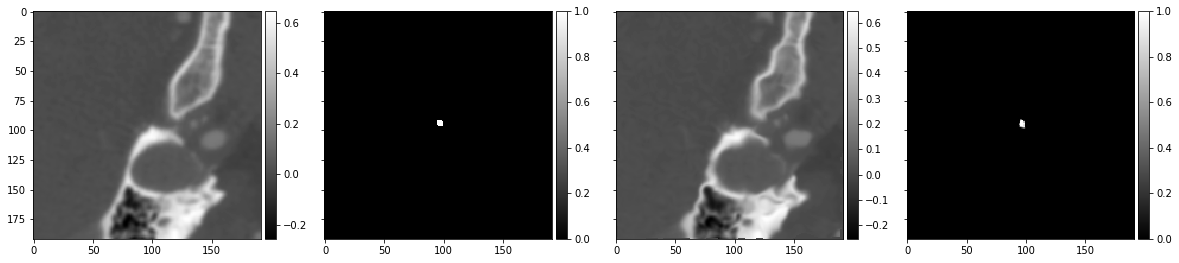

(192, 192, 1) (192, 192)


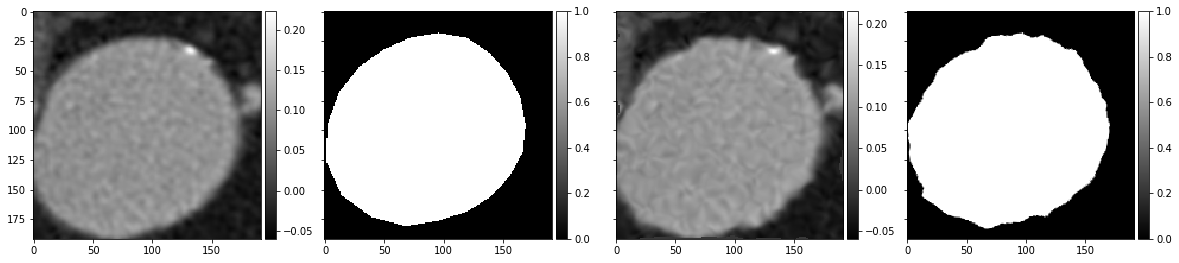

(192, 192, 1) (192, 192)


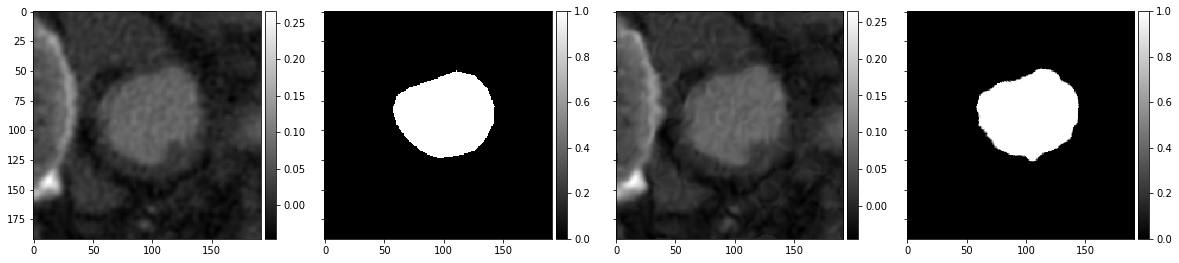

In [4]:
######################################################
# Plot
######################################################
alpha=34
sigma=4
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['figure.figsize'] = (20.0, 10.0)
def implot(mp,ax):
    im = ax.imshow(mp.astype(np.float32), cmap='gray')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
 
for i in range(7):
    j = np.random.randint(N)
    x_im = f_train.root.X[j].astype(np.float32)
    y_im = f_train.root.Y[j].astype(np.float32)
    
    trans = util.elastic_transform([x_im[:,:,0],y_im[:,:,0]],alpha,sigma)
    x_trans = trans[0]
    y_trans = trans[1]

    print x_im.shape, x_trans.shape
    plt.figure()
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
    implot(x_im[:,:,0],ax1)
    implot(y_im[:,:,0],ax2)
    implot(x_trans[:,:],ax3)
    implot(y_trans[:,:],ax4)
    plt.tight_layout
    #plt.savefig('transform_{}.pdf'.format(j),dpi=600)
    plt.show()

In [7]:
def get_batch(X,Y,N,n=32, gen_angles=True, crop_dims=128, offset=3, noise=0.0, alpha=34, sigma=5):
    inds = np.random.choice(range(N),size=n, replace=False)
    x = X[inds,:,:,0].astype(np.float32)
    y = Y[inds,:,:,0].astype(np.float32)

#     #rotations
    if gen_angles:
        angles = np.random.randint(360, size=x.shape[0])
        xrot = np.zeros(x.shape)
        yrot = np.zeros(y.shape)
    for i in range(len(angles)):
        xrot[i] = rotate(x[i],angles[i], axes=(1,0), reshape=False)
        yrot[i] = rotate(y[i],angles[i], axes=(1,0), reshape=False)
#         yrot[i] = (yrot[i]-np.amin(yrot[i]))/(np.amax(yrot[i])-np.amin(yrot[i]))
#     xrot = x
#     yrot = y
    #random crops
    space = offset
    starts = np.random.randint(space, size=[x.shape[0],2])*2 - space
    startsx = W/2-crop_dims/2+starts[:,0]
    startsy = H/2-crop_dims/2+starts[:,1]
    
    xret = np.zeros((n,crop_dims,crop_dims)).astype(float)
    yret = np.zeros((n,crop_dims,crop_dims)).astype(float)
    for i in range(x.shape[0]):
        ims = [xrot[i],yrot[i]]
        im_list = util.elastic_transform(ims,alpha,sigma)
        xrot[i] = im_list[0]
        yrot[i] = im_list[1]
        
        xret[i] = xrot[i,startsx[i]:startsx[i]+crop_dims,startsy[i]:startsy[i]+crop_dims]

        yret[i] = yrot[i,startsx[i]:startsx[i]+crop_dims,startsy[i]:startsy[i]+crop_dims]


        
    xret = xret[:,:,:,np.newaxis]
    yret = yret[:,:,:,np.newaxis]

    xret = xret+(2*np.random.rand()-1)*noise
    return xret,yret

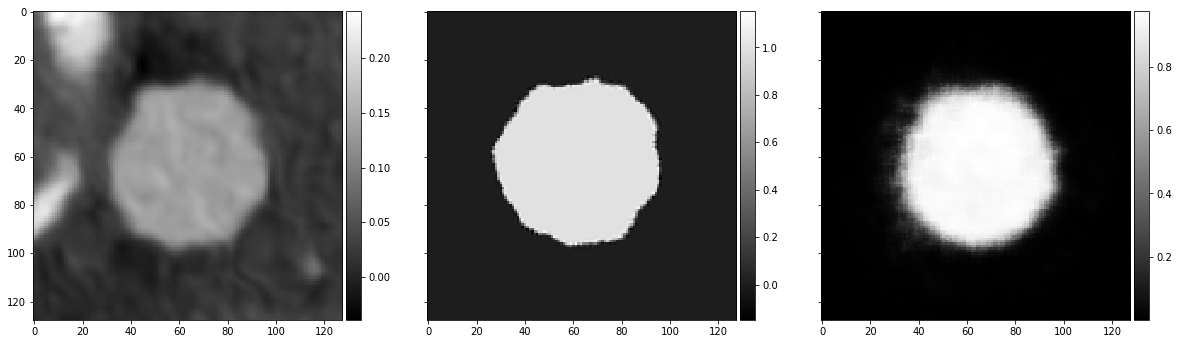

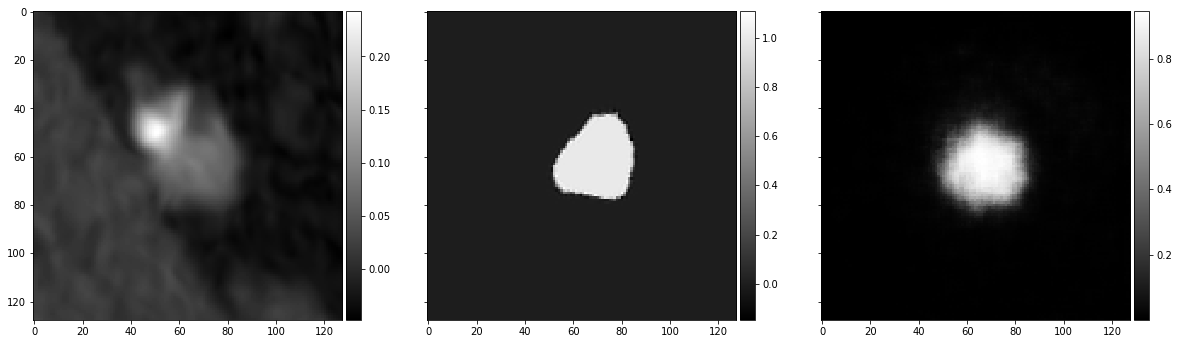

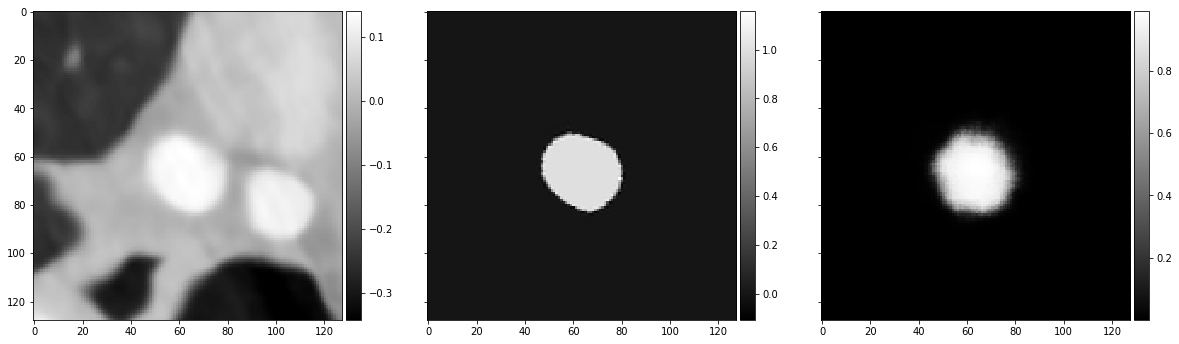

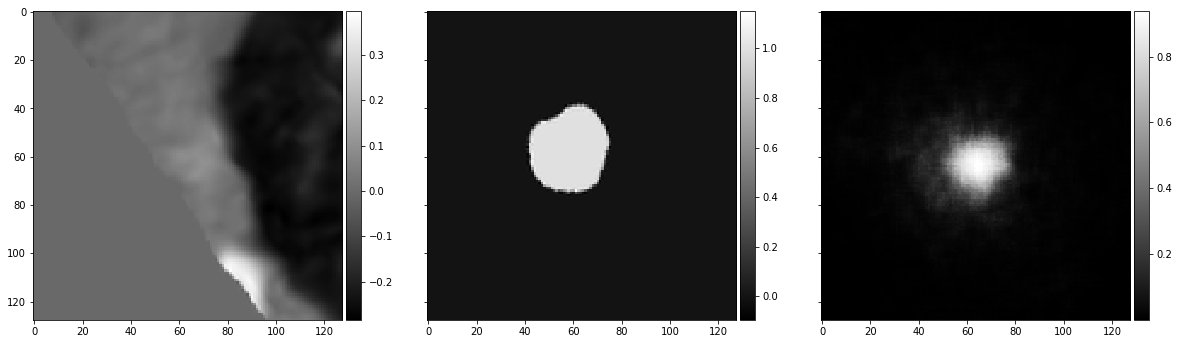

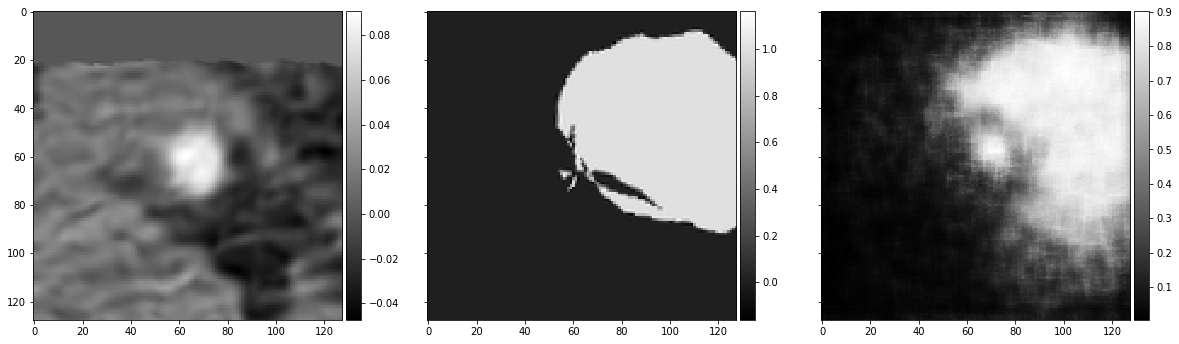

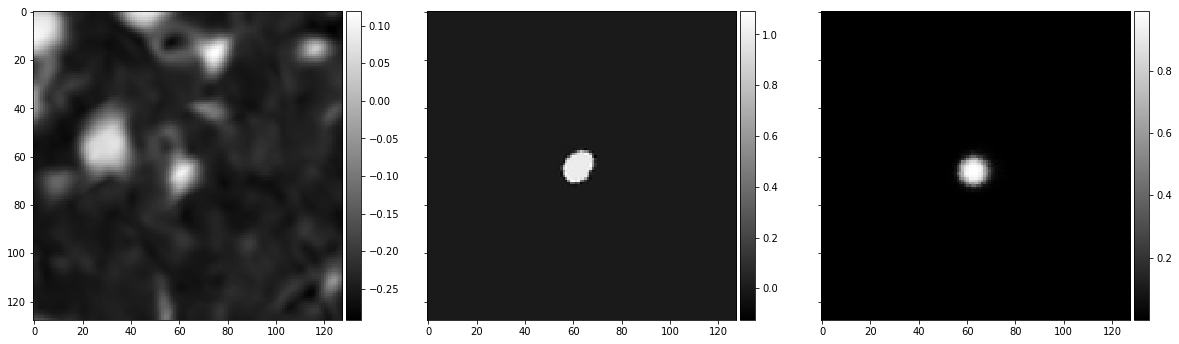

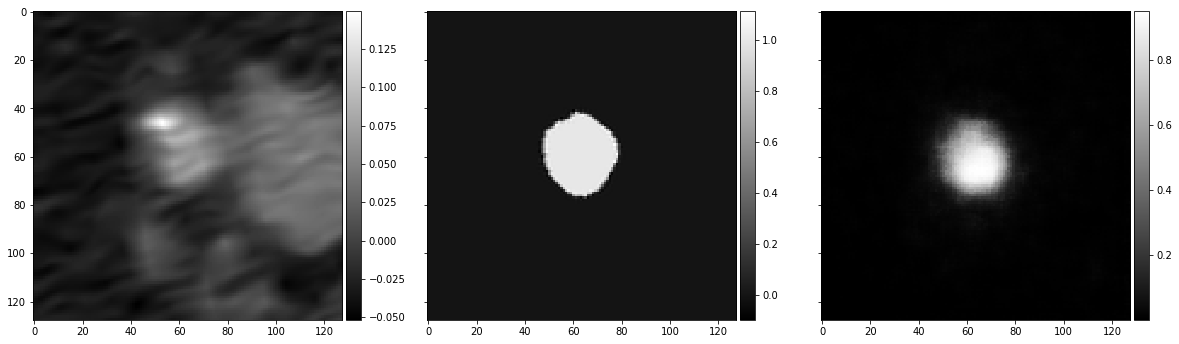

In [8]:
######################################################
# Plot
######################################################
    
xb,yb = get_batch(f_train.root.X,f_train.root.Y,N,n=Nbatch,crop_dims=crop_dims)
# yout,yhat_out,x_vec_out,minput =sess.run([yclass,yhat,x_vec_sig,masked_input],{x:xb,y:yb})
yout,yhat_out =sess.run([yclass,yhat],{x:xb,y:yb}) 
for i in range(7):
    xval = xb[i:i+2]
    yval = yb[i:i+2][:,:,:,:]
    ypred = yout[i:i+2]
#     ypred_ = x_vec_out[i:i+2]
#     minput_ = minput[i:i+2]
    
    plt.figure()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    implot(xval[0,:,:,0],ax1)
    implot(yval[0,:,:,0],ax2)
    implot(ypred[0,:,:,0],ax3)
#     implot(ypred_[0,:,:,0],ax4)
#     implot(minput_[0,:,:,0],ax5)
    plt.tight_layout
    plt.show()

In [9]:
print xval.shape
print yval.shape
print yout.shape

(2, 128, 128, 1)
(2, 128, 128, 1)
(16, 128, 128, 1)


In [10]:
# #######################################################
# # Train positive
# #######################################################
train_hist = []
val_hist = []

for i in range(Nsteps+1):
    xb,yb = get_batch(f_train.root.X,f_train.root.Y,N,n=Nbatch,crop_dims=crop_dims)
    l,_=sess.run([loss,train],{x:xb,y:yb})
#     if (i+1)%3000 == 0:
#         lr = lr/10
    if i%(print_step)==0:
        print "iteration {}".format(i)

        xb,yb = get_batch(f_val.root.X,f_val.root.Y,Nval,Nbatch,crop_dims=crop_dims)
        lval,ypred=sess.run([loss,yclass],{x:xb,y:yb})
        print "Train: {}, Val: {}, p var {}, p mean {}, p max {}, p min {}".format(l,lval,
                np.var(ypred),np.mean(ypred), np.amax(ypred),np.amin(ypred))

        saver.save(sess,'./models/i2i_{}/i2i_{}'.format(MODEL_CODE,MODEL_CODE))
        
        train_hist.append(l)
        val_hist.append(lval)

iteration 0
Train: 0.0520898289979, Val: 0.10100903362, p var 0.0222757551819, p mean 0.0565607324243, p max 0.976946175098, p min 2.15845670937e-06
iteration 200
Train: 0.0433765538037, Val: 0.19598659873, p var 0.0181164499372, p mean 0.0423029214144, p max 0.996033728123, p min 5.28054489024e-09
iteration 400
Train: 0.167678341269, Val: 0.233177289367, p var 0.0121532334015, p mean 0.0346058644354, p max 0.977080345154, p min 3.09508649821e-08
iteration 600
Train: 0.0450236462057, Val: 0.249113172293, p var 0.0313838683069, p mean 0.0707081258297, p max 0.996089994907, p min 4.17448881018e-10
iteration 800
Train: 0.0724575594068, Val: 0.124312371016, p var 0.0664387494326, p mean 0.109351836145, p max 0.996145606041, p min 1.1749258455e-08
iteration 1000
Train: 0.0742658898234, Val: 0.246056243777, p var 0.0256905965507, p mean 0.0748728886247, p max 0.990981042385, p min 3.31505987106e-07
iteration 1200
Train: 0.0517284162343, Val: 0.12976449728, p var 0.0268432684243, p mean 0.072

KeyboardInterrupt: 

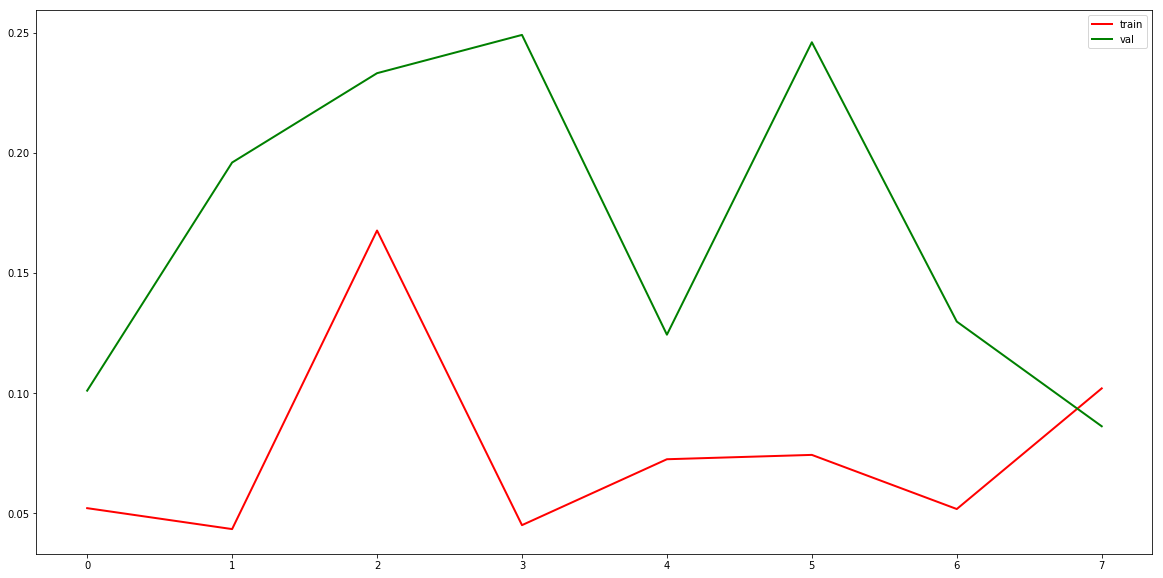

In [11]:
plt.figure()
plt.plot(train_hist, linewidth=2,color='r',label='train')
plt.plot(val_hist, linewidth=2,color='g',label='val')
plt.legend()
plt.show()

In [12]:
f_test = tables.open_file(test)
print f_test.root.X.shape

(42694, 192, 192, 1)


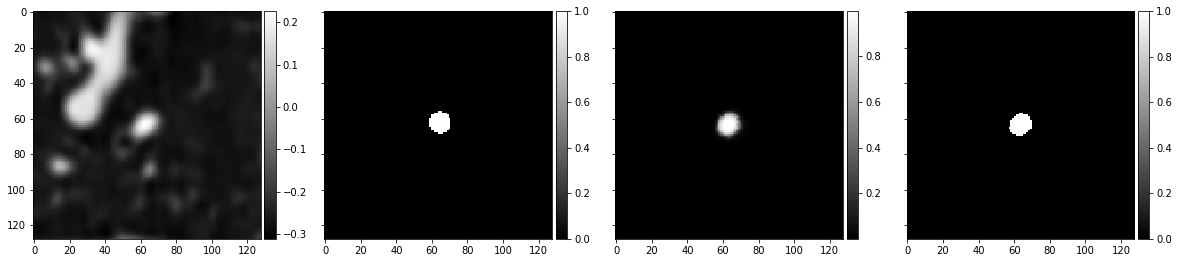

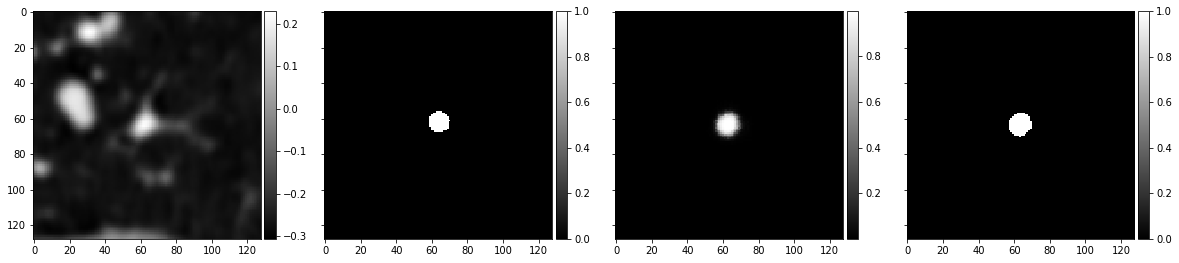

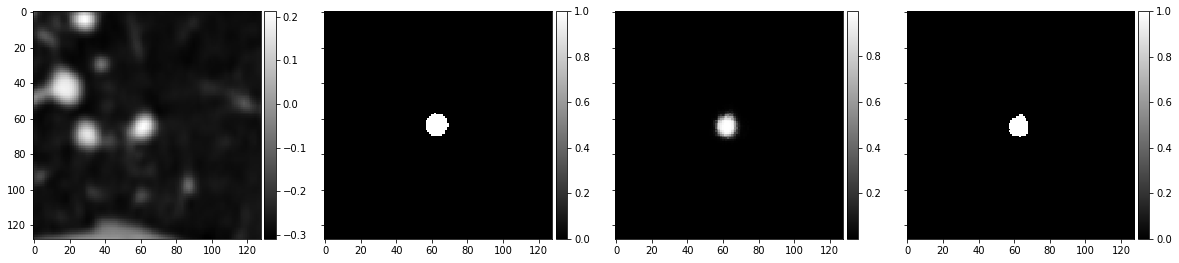

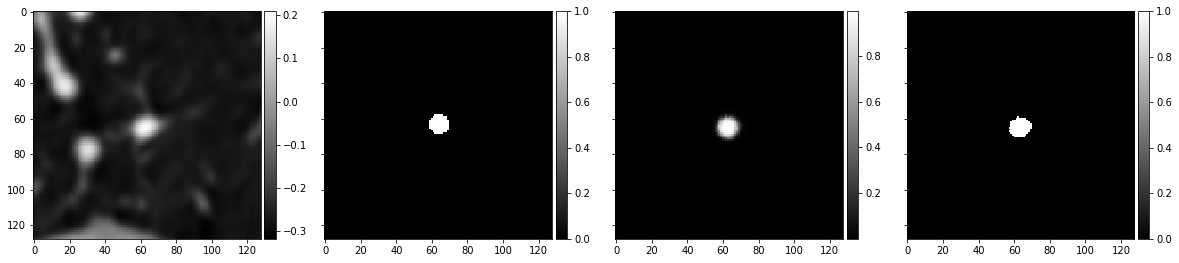

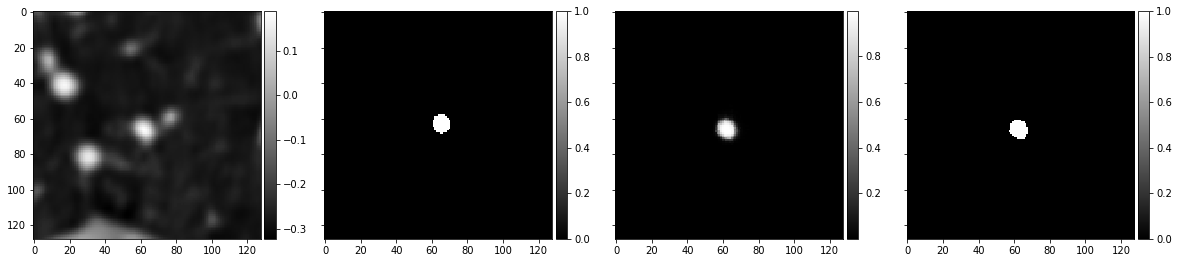

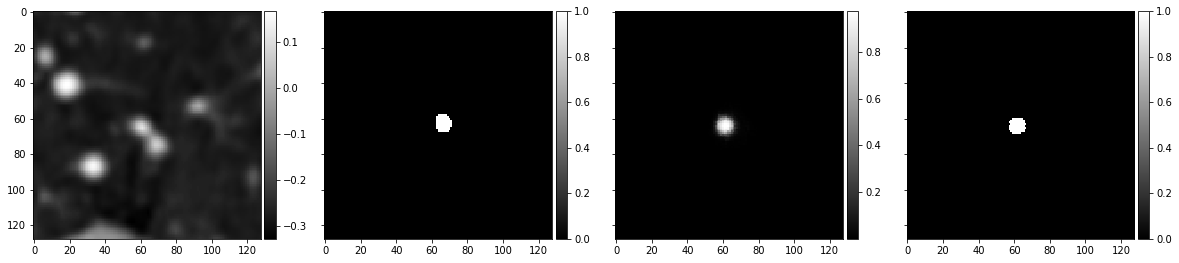

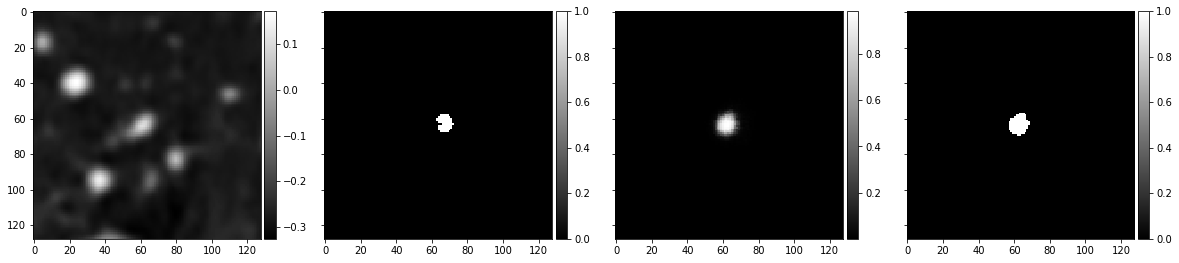

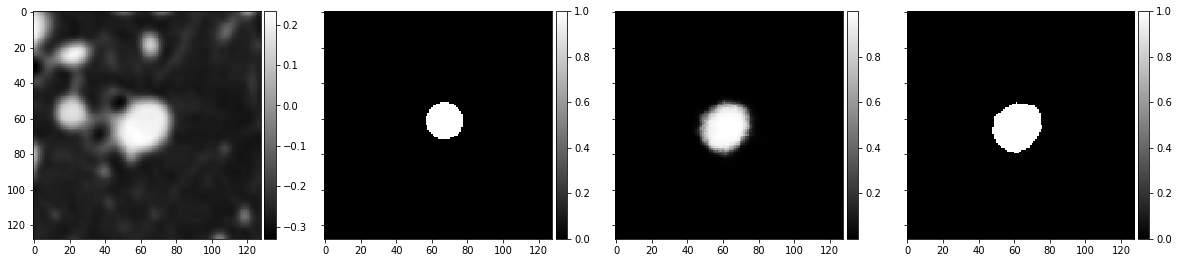

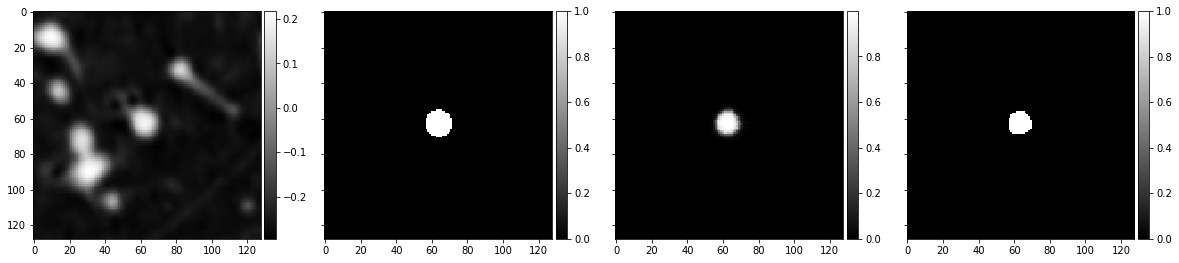

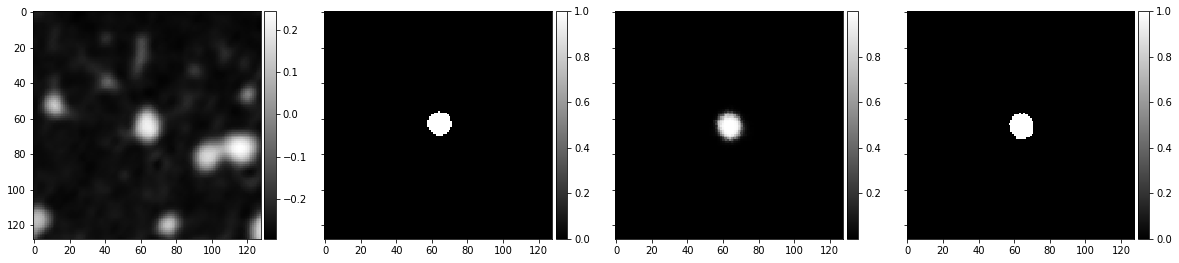

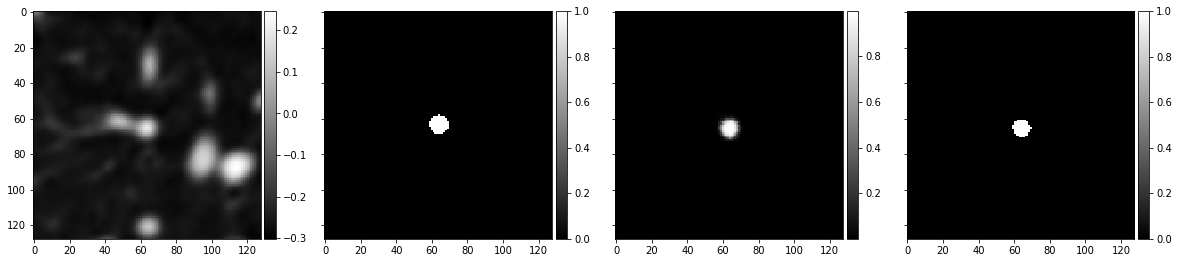

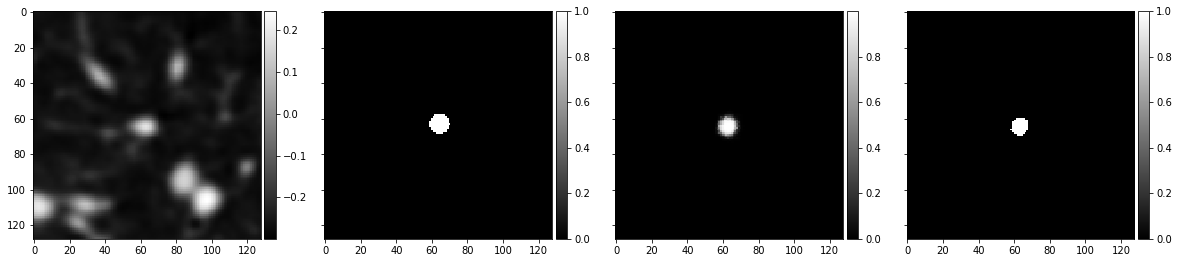

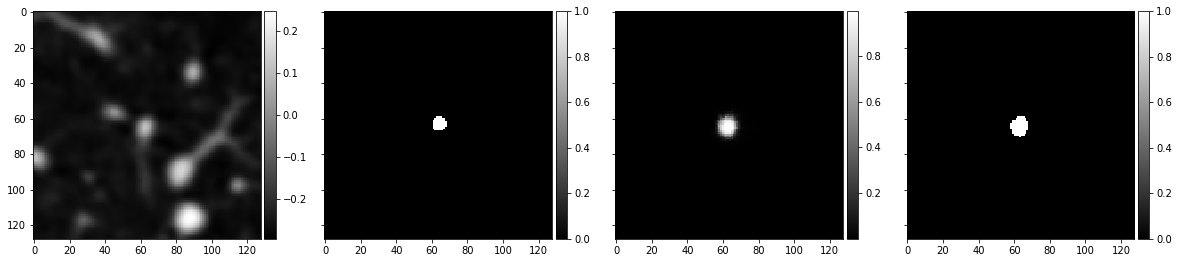

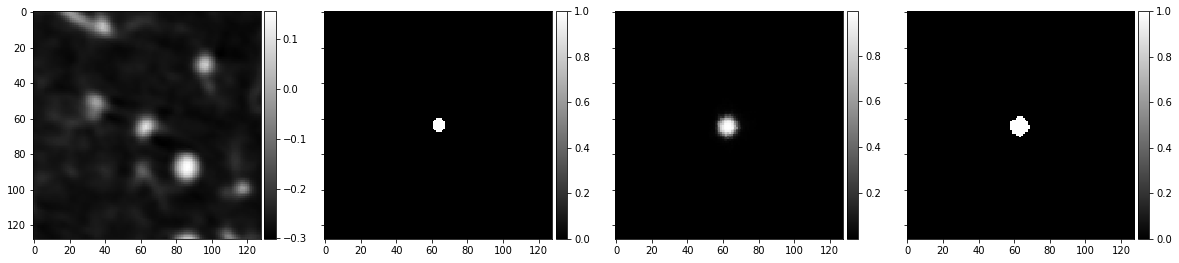

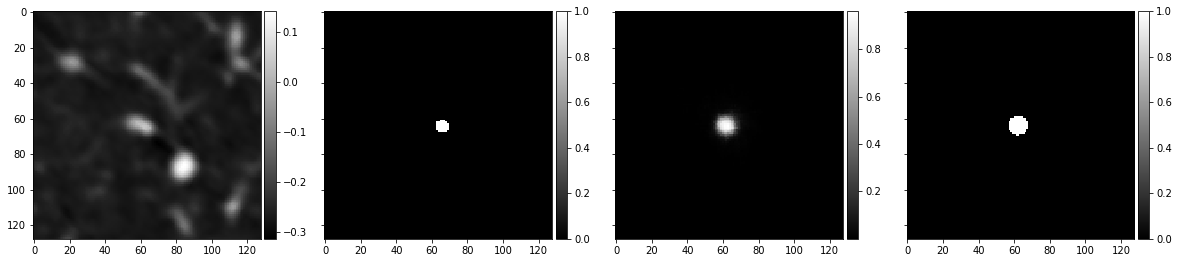

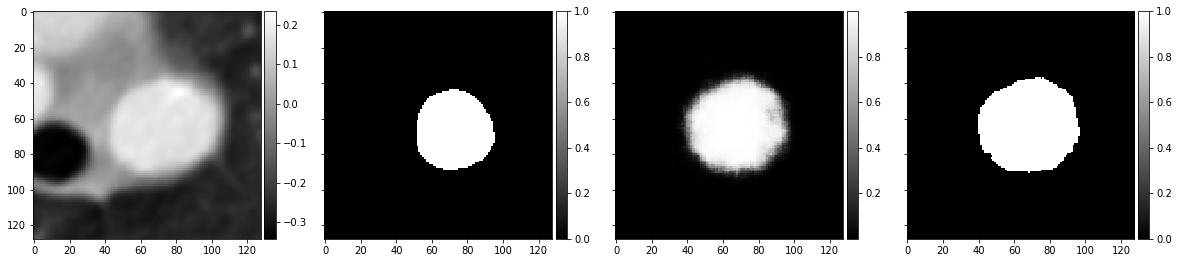

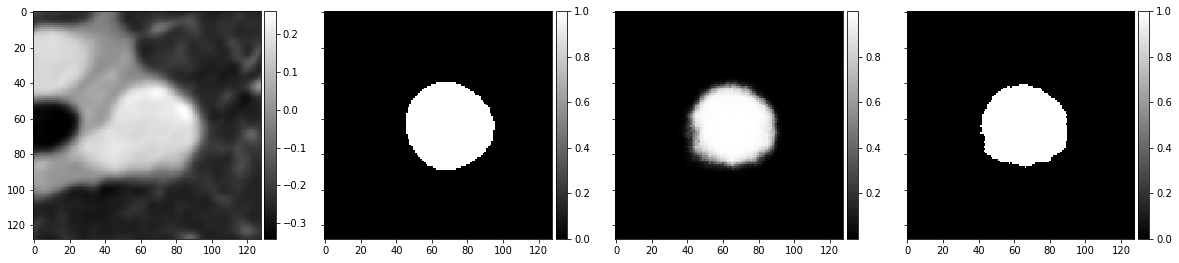

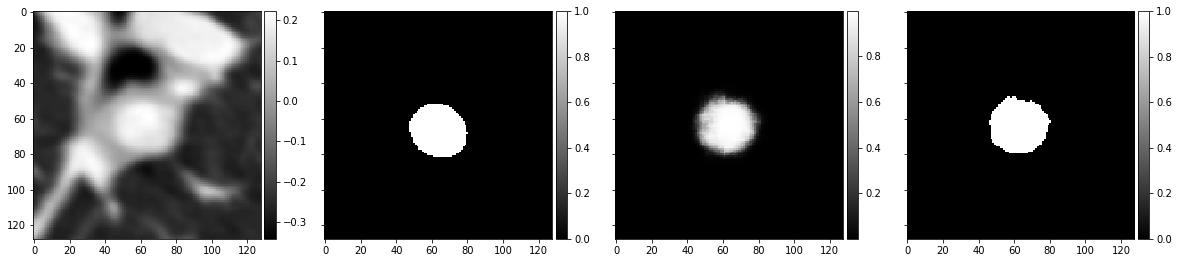

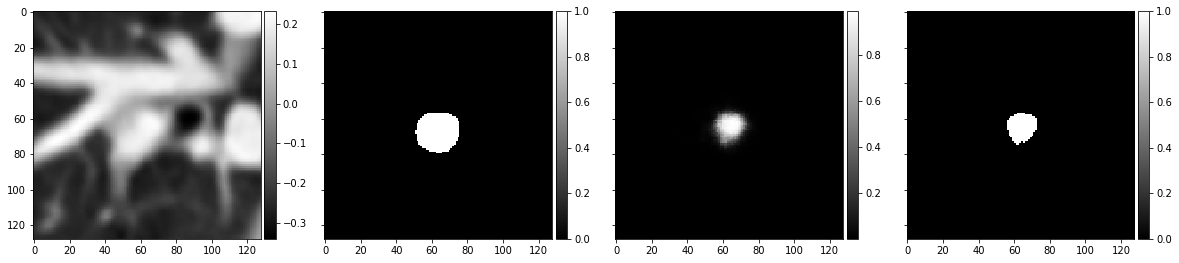

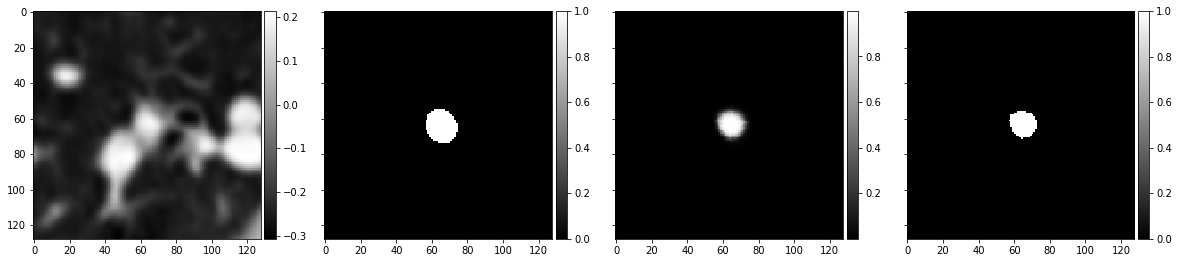

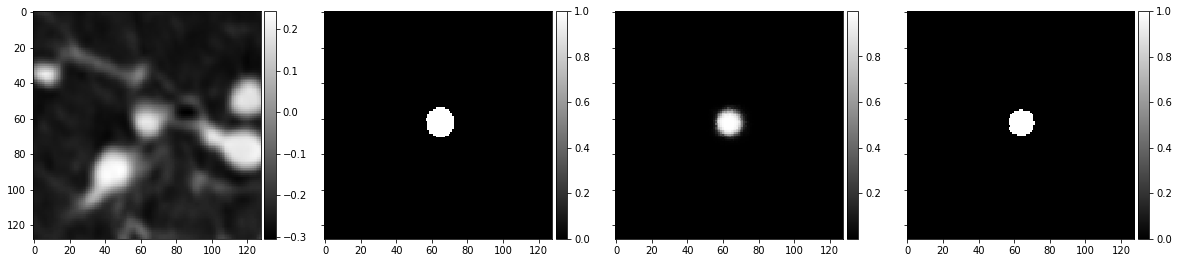

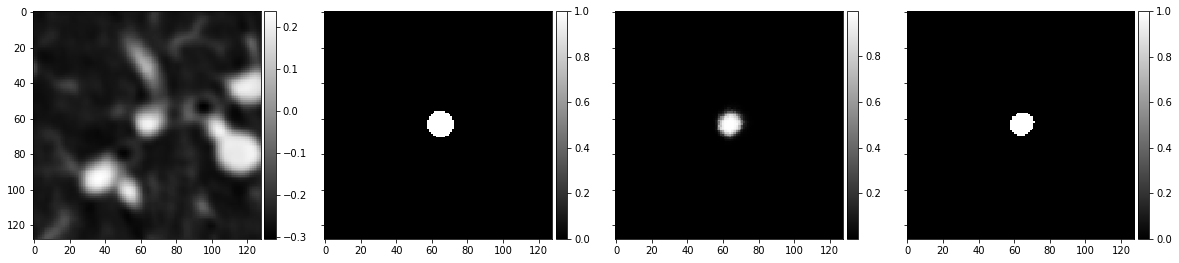

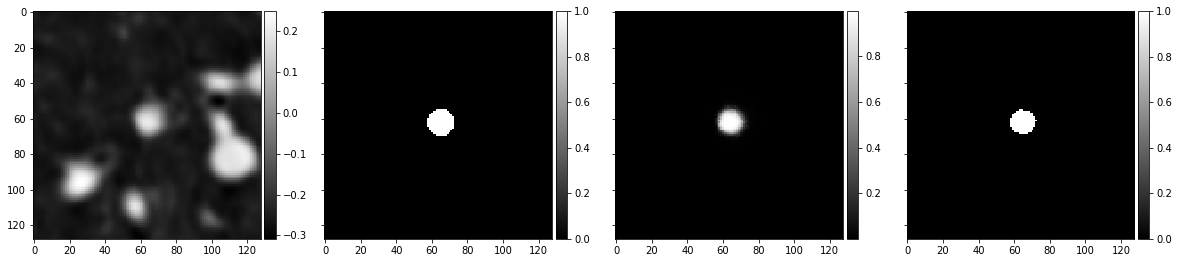

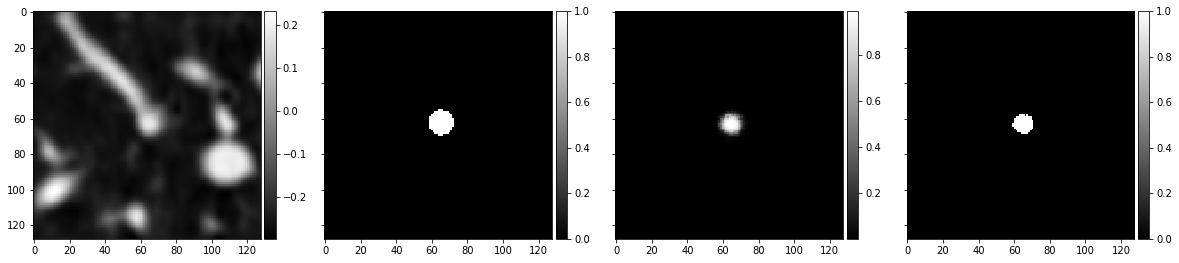

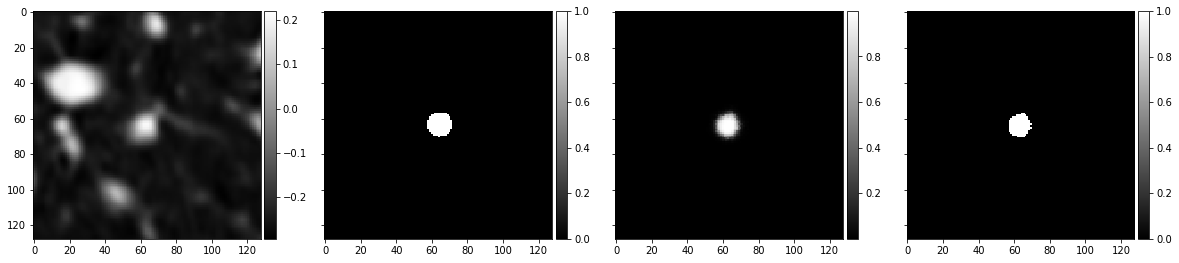

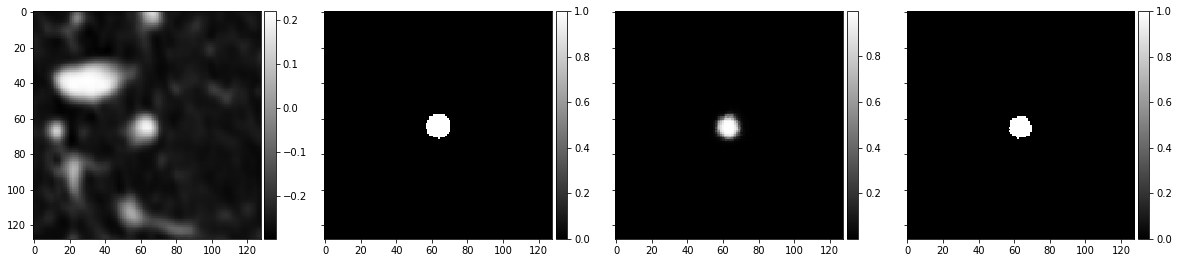

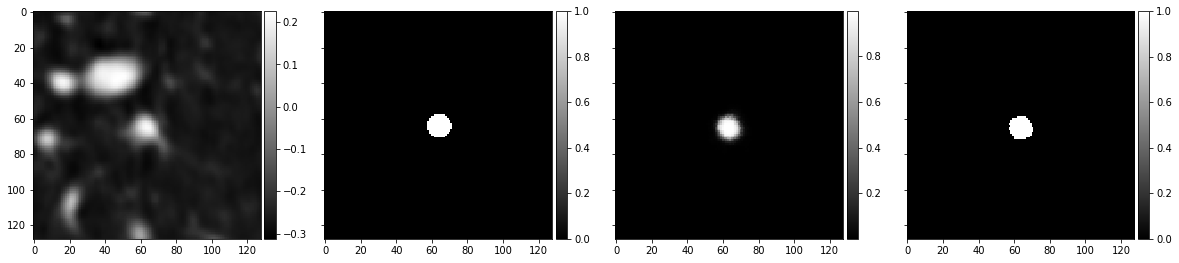

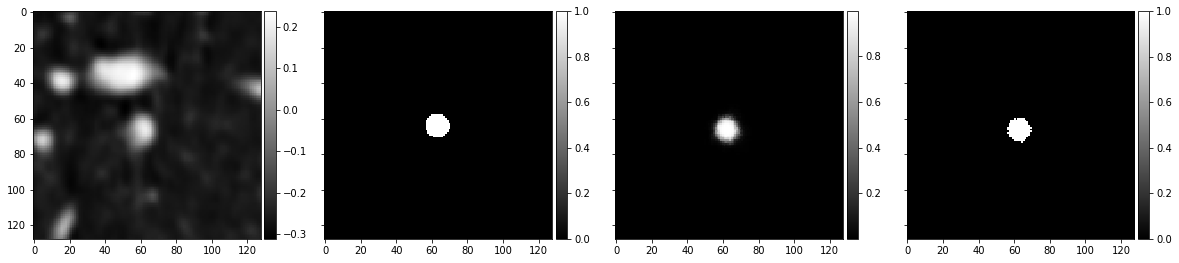

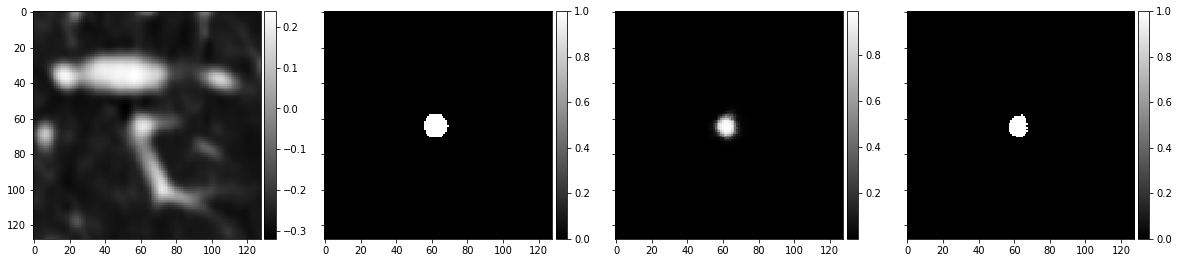

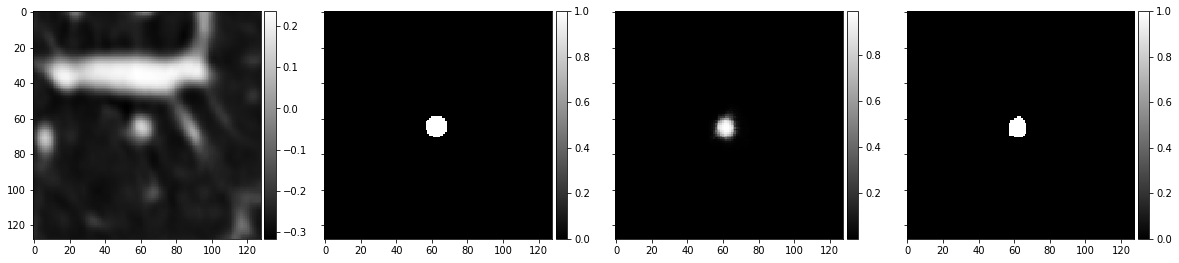

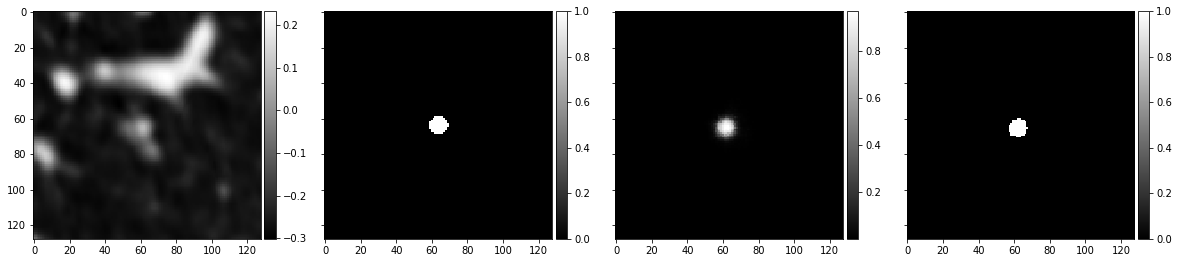

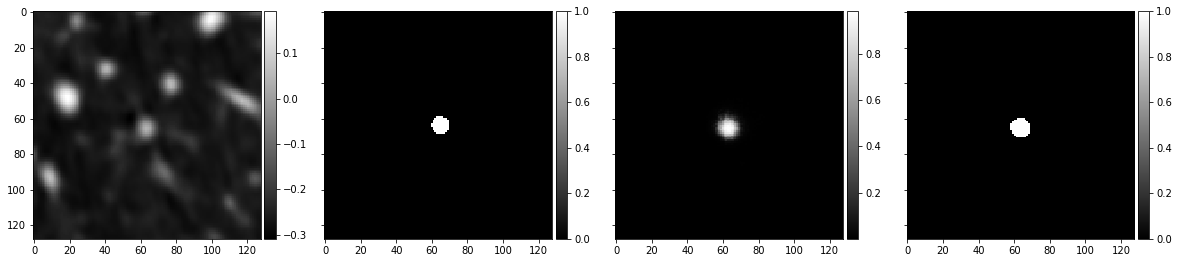

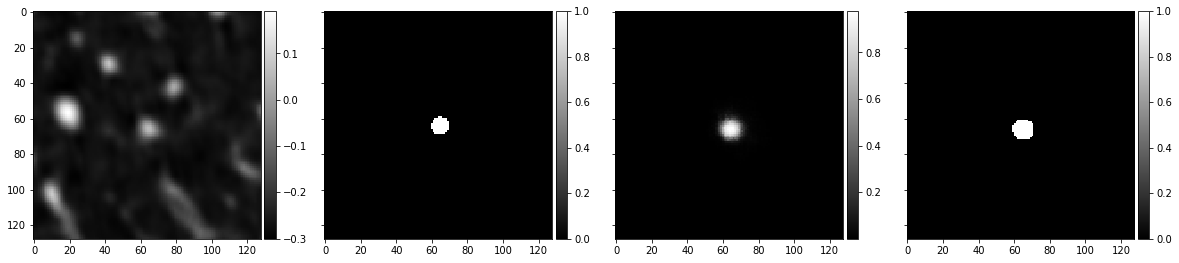

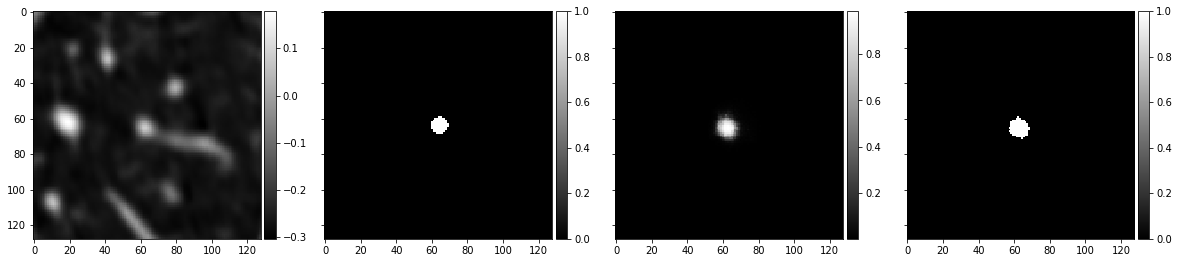

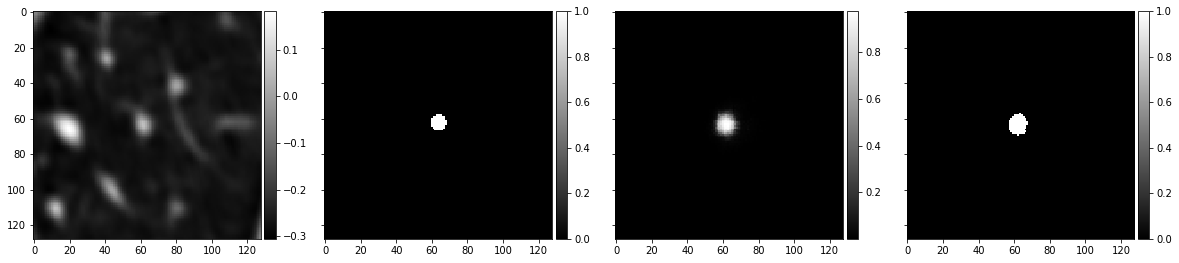

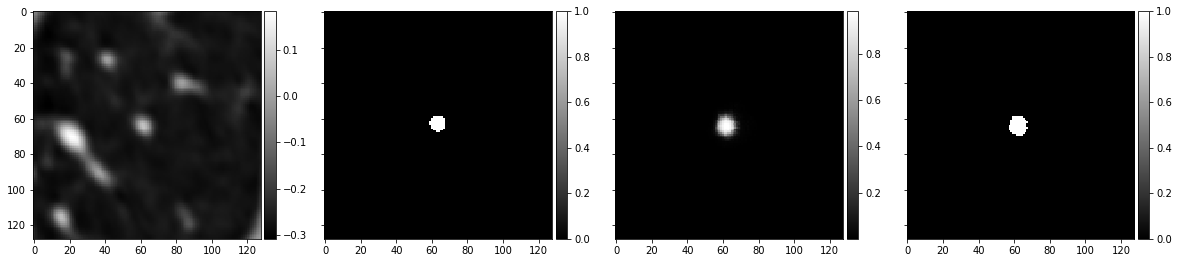

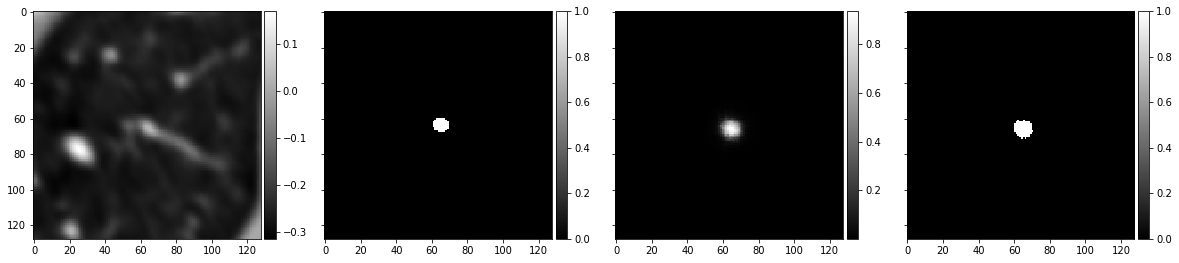

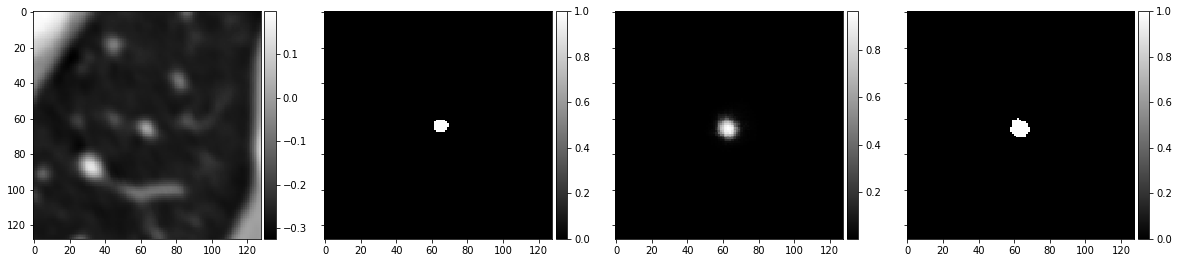

In [13]:
N=f_test.root.X.shape[0]
n=Nbatch 
from scipy.ndimage.morphology import binary_fill_holes, binary_erosion
INDS = range(17127,17500,10)
# for j in range(20):
for j in INDS:
#     i = np.random.randint(N)
    i = j
    xb = util.crop_center_nd(f_test.root.X[i:i+n], 
                                crop_dims,crop_dims).astype(float)
    yb = util.crop_center_nd(f_test.root.Y[i:i+n],
                                crop_dims, crop_dims)
    ypred = sess.run(yclass,{x:xb,y:yb})
    plt.figure()
    fig, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4, sharey=True)
    implot(xb[0,:,:,0],ax1)
    implot(yb[0,:,:,0],ax2)
    implot(ypred[0,:,:,0],ax3)
    implot(binary_erosion(binary_fill_holes(util.threshold(ypred[0,:,:,0],0.2))),ax4)
    plt.tight_layout
    plt.show()
    
    np.save('/home/marsdenlab/{}.npy'.format(i),xb[0,:,:,0].reshape((1,crop_dims,crop_dims,1)))

In [14]:
N=f_test.root.X.shape[0]
print N
ypred=np.zeros((N,crop_dims,crop_dims,1)).astype(float)
ytrue=np.zeros((N,crop_dims,crop_dims,1)).astype(float)

for i in range(0,N,Nbatch):
    if i%1000 == 0:
        print i
    xb = util.crop_center_nd(f_test.root.X[i:i+Nbatch], 
                                crop_dims,crop_dims)
    yb = util.crop_center_nd(f_test.root.Y[i:i+Nbatch],
                                crop_dims, crop_dims)
    a = Nbatch
    if xb.shape[0] < Nbatch:
        a = xb.shape[0]
        print a
        tempx = np.zeros((Nbatch,crop_dims,crop_dims,1))
        tempy = np.zeros((Nbatch,crop_dims,crop_dims,1))
        
        tempx[:xb.shape[0]] = xb.copy()
        tempy[:xb.shape[0]] = yb.copy()
        
        xb = tempx.copy()
        yb = tempy.copy()
    yout =sess.run(yclass,{x:xb,y:yb})
    
    if a < Nbatch:
        ypred[i:i+Nbatch] = yout[:a].copy()
        ytrue[i:i+Nbatch] = yb[:a].copy()

    else:
        ypred[i:i+Nbatch] = yout.copy()
        ytrue[i:i+Nbatch] = yb.copy()

np.save('i2i_segs_{}.npy'.format(MODEL_CODE),ypred)

42694
0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
34000
36000
38000
40000
42000
6


In [15]:
conts = []
for i in range(N):
    if i %1000==0:
        print i
    seg = ypred[i,:,:,0]
    seg = util.threshold(seg,0.2)
    seg = binary_fill_holes(seg)
    cont = util.marchingSquares(seg.astype(np.float32),iso=0.5,mode='center')
    conts.append(cont.copy())
    

np.save('i2i_conts_{}.npy'.format(MODEL_CODE),conts)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000


KeyboardInterrupt: 

In [26]:
# saver = tf.train.Saver()
# saver.save(sess,'./models/i2i/i2i')

'./models/i2i/i2i'

In [4]:
# saver = tf.train.Saver()
saver.restore(sess,'./models/i2i_{}/i2i_{}'.format(MODEL_CODE,MODEL_CODE))

INFO:tensorflow:Restoring parameters from ./models/i2i_CT/i2i_CT


In [5]:
mhas = open('images.txt').readlines()
mhas = [i.replace('\n','') for i in mhas]
# mhas = [i.split('/')[-1] for i in mhas]
# mhas = ['./data/'+i for i in mhas]

truths = open('truths.txt').readlines()
truths = [i.replace('\n','') for i in truths]

paths = open('paths.txt').readlines()
paths = [i.replace('\n','') for i in paths]

groups = open('groups.txt').readlines()
groups = [i.replace('\n','') for i in groups]

ct_test = open('ct_test.txt').readlines()
ct_test = [i.replace('\n','') for i in ct_test]

test_images = []
for i in range(len(mhas)):
    if any([c in mhas[i] for c in ct_test]):
        test_images.append((mhas[i],truths[i],paths[i],groups[i]))
        
print test_images

[('/home/marsdenlab/datasets/vascular_data/OSMSC0004/OSMSC0004-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0004/0004_0001/0004_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0004/0004_0001/0004_0001-cm.paths', '/home/marsdenlab/datasets/vascular_data/OSMSC0004/0004_0001/0004_0001_groups-cm'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0119/OSMSC0119-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0119/0119_0001/0119_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0119/0119_0001/0119_0001-cm.paths', '/home/marsdenlab/datasets/vascular_data/OSMSC0119/0119_0001/0119_0001_groups-cm'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0144/OSMSC0144-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0144/0144_1001/0144_1001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0144/0144_1001/0144_1001-cm.paths', '/home/marsdenlab/datasets/vascular_data/OSMSC0144/0144_1001/0144_1001_groups-cm'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0

In [6]:
from scipy.ndimage.morphology import binary_fill_holes, binary_erosion
def batch_seg(X,crop_dims):
    nbatch=Nbatch
    N=X.shape[0]
    ypred=np.zeros((N,crop_dims,crop_dims,1)).astype(float)

    for i in range(0,N,Nbatch):
        a = Nbatch
        xb = X[i:i+Nbatch]
        
        if xb.shape[0] < Nbatch:
            a = xb.shape[0]
            tempx = np.zeros((Nbatch,crop_dims,crop_dims,1))

            tempx[:xb.shape[0]] = xb.copy()

            xb = tempx.copy()
            
        yout =sess.run(yclass,{x:xb}).astype(float)

        if a < Nbatch:
            ypred[i:i+Nbatch] = yout[:a]

        else:
            ypred[i:i+Nbatch] = yout
        
    ypred = util.threshold(ypred,0.1)
    L = ypred.shape[0]
    for i in range(L):
        ypred[i,:,:,0] = np.flipud(ypred[i,:,:,0])
        ypred[i,:,:,0] = binary_fill_holes(ypred[i,:,:,0])
    return ypred.copy()

def reorder_contour(c):
    N = len(c)
    even_inds = np.arange(0,N,2)
    odd_inds = np.arange(1,N,2)
    
    even_points = np.asarray([c[i] for i in even_inds])
    odd_points = np.asarray([c[i] for i in odd_inds])
    
    N_even = len(even_points)
    ret = np.zeros_like(c)
    ret[:N_even] = even_points
    ret[N_even:] = np.flipud(odd_points)
    ret = ret[:-2]
    return ret.copy()

def ct_norm(x,im):
    return (1.0*x)/(3000)

In [7]:
import vtk
import os

util.mkdir('pred_groups')

In [8]:

ext = [127, 127]
DIMS = [128,128]
ISOVALUE=0.5
NUM_MODES = 5


In [9]:
util.gen_groups(test_images,batch_seg,ct_norm,ext,DIMS,ISOVALUE,NUM_MODES,
                crop_dims,'i2ifc','./pred_groups')

/home/marsdenlab/datasets/vascular_data/OSMSC0004/OSMSC0004-cm.mha
(0.025, 0.025, 0.025)
profunda_branch_left
profunda_left
knee_right
profunda_branch_right
anterior_tibial_right
knee_left
anterior_tibial_left
posterior_tibial_right
femoral_right
posterior_tibial_left
femoral_left
aorta_leg_right
celiac
leg_left
renal_right
superior_mesenteric_artery
internal_iliac_right
renal_left
profunda_right
internal_iliac_left
/home/marsdenlab/datasets/vascular_data/OSMSC0119/OSMSC0119-cm.mha
(0.025, 0.025, 0.025)
LPA_br3
LPA_br3_br1
LPA_br1_br1_br4
LPA_br1_br1_br4_br1
LPA_br1_br1_br0
LPA_br1_br1_br2
LPA_br2_br1_br1
LPA_br1_br1_br1
LPA_br3_br2
LPA_br4
LPA_br6
LPA_br5
RPA_br11_br1
RPA_br11_br2
RPA_br11_br3
RPA_br6_br1
RPA_br10_br1
RPA_br10_br2
RPA_br10_br3
RPA_br10_br4
LPA_br13_br2_br1
LPA_br13_br2
LPA_br16
LPA_br15
RPA_br6_br2
LPA_br17
LPA_br4_br4_br3
LPA_br4_br4_br2
LPA_br4_b2_br3
LPA_br4_b2_br2_br1
LPA_br4_b2_br2
LPA_br4_b2_br1
LPA_br12_br2
LPA_br12_br1
LPA_br4_b2_br4
LPA_br4_b2_br3_b1
LPA_br10